## Basic analysis

In [1]:
#Libraries and main variables initialized
import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import rmsd
import numpy as np
import urllib.request, json
import os
import re
import nglview as nv
from funcs import get_files_from_git
from funcs import view_nucl


import matplotlib.pyplot as plt

import MDAnalysis.analysis.pca as pca
import MDAnalysis.analysis.encore as encore
from MDAnalysis.analysis.rms import RMSF

from seq_tools.plot4seq import plot_prof4seq
from Bio.Align import MultipleSeqAlignment
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqUtils import seq1
from seq_tools.hist_ss import get_hist_ss_in_aln_for_shade
import numpy as np
import xvg_plot as xvg
import xpm_plot as xpm

#Reloading funcs if changed
from importlib import reload 
import funcs,config
reload(funcs)
reload(config)


%matplotlib inline
%load_ext rpy2.ipython

from config import movtitle
from IPython.display import Markdown, display
from config import folder,descr,pname
display(Markdown(descr))
print("Folder set to: ",folder)
print("Project name: ",pname)




# MD simulations of H3-H4 with 30 bp of DNA, tails truncated
- AMBER14SB force field
- 50 mM NaCl
- box 2nm


Folder set to:  h3-h4_tm_DNA
Project name:  h3-h4_tm_DNA


## Let's preview

In [2]:
view_nucl('GMX_system/sys_ref.pdb', 'big_data/sys_md.xtc')


## Movie

NGLWidget(count=73)

In [10]:
#args 1 1 will trigger generation of images for movie in tmp/dat
!rm tmp/dat/*
!vmd -dispdev none -e VMD_scripts/view_nucl.tcl -args GMX_system/sys_ref.pdb big_data/sys_md.xtc "$movtitle" 0 1 1 1 1 > /dev/null
!rm big_data/movie.*
!ffmpeg -i tmp/dat/%d.dat.tga -s 1000x750 -q:v 0 -pix_fmt yuv420p  big_data/movie.mp4 > /dev/null 2>&1
#!ffmpeg -i tmp/dat/%d.dat.tga -s 1000x750 -q:v 0 -pix_fmt yuv420p  big_data/movie.wmv

/opt/miniconda3/envs/moldyn/vmd/vmd_LINUXAMD64: /usr/lib/x86_64-linux-gnu/libGL.so.1: no version information available (required by /opt/miniconda3/envs/moldyn/vmd/vmd_LINUXAMD64)


In [11]:
#Make a smooth movie
!vmd -dispdev none -e VMD_scripts/view_nucl.tcl -args GMX_system/sys_ref.pdb big_data/sys_md.xtc "$movtitle, smoothed" 20 1 1 1 > /dev/null
!rm big_data/movie_sm20.*
!ffmpeg -i tmp/dat/%d.dat.tga -s 1000x750 -q:v 0 -pix_fmt yuv420p  big_data/movie_sm20.mp4 > /dev/null 2>&1
#!ffmpeg -i tmp/dat/%d.dat.tga -s 1000x750 -q:v 0 -pix_fmt yuv420p  big_data/movie_sm20.wmv

/opt/miniconda3/envs/moldyn/vmd/vmd_LINUXAMD64: /usr/lib/x86_64-linux-gnu/libGL.so.1: no version information available (required by /opt/miniconda3/envs/moldyn/vmd/vmd_LINUXAMD64)
rm: cannot remove 'big_data/movie_sm20.*': No such file or directory


In [12]:
%%HTML
<video width="320" height="240" controls>
  <source src="big_data/movie.mp4" type="video/mp4">
</video>
<video width="320" height="240" controls>
  <source src="big_data/movie_sm20.mp4" type="video/mp4">
</video>

## RMSD, radius of gyration

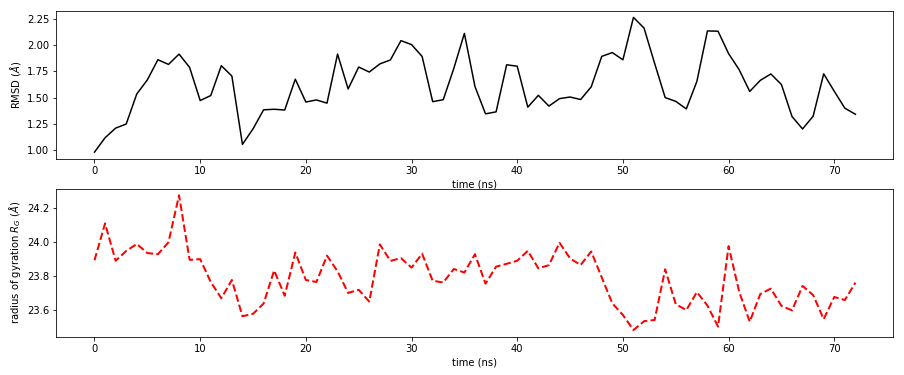

In [13]:
#MDAnalysis
trj=mda.Universe('GMX_system/sys_ref.pdb', 'big_data/sys_md.xtc')
ref = mda.Universe('GMX_system/sys_ref.pdb')
R = mda.analysis.rms.RMSD(trj, ref, select="protein and backbone",filename="big_data/rmsd.dat")
R.run()

rmsd = R.rmsd.T   # transpose makes it easier for plotting

time = list(map(lambda x: x/1000,rmsd[1]))

prot = trj.select_atoms("protein or nucleic")
Rgyr=[]
for ts in trj.trajectory[::1]:
   Rgyr.append((trj.trajectory.time, prot.radius_of_gyration()))
Rgyr = np.array(Rgyr)

plt.figure(figsize=(15,6))
ax = plt.subplot(211)
ax.plot(time, rmsd[2], 'k-',  label="backbone")
ax.set_xlabel("time (ns)")
ax.set_ylabel(r"RMSD ($\AA$)")

ax2 = plt.subplot(212)
ax2.plot(time, Rgyr[:,1], 'r--', lw=2, label=r"$R_G$")
ax2.set_xlabel("time (ns)")
ax2.set_ylabel(r"radius of gyration $R_G$ ($\AA$)")

plt.draw()

## RMSF along the sequence

In [14]:
# Let's extract the sequence
u=mda.Universe('GMX_system/sys_ref.pdb')
#prot = nuclMD.select_atoms("protein")
#u.select_atoms('segid A and protein').segments.resnames[0]
#list(u.select_atoms('segid A and protein').segments.resnames[0])
chainA_seq=seq1(''.join(list(u.select_atoms('segid A and protein').segments.resnames[0])))
chainB_seq=seq1(''.join(list(u.select_atoms('segid B and protein').segments.resnames[0])))
print(chainA_seq)
#Let's get features
msaH3=MultipleSeqAlignment([SeqRecord(Seq(chainA_seq[1:]),id='H3',name='H3')])
featuresH3=get_hist_ss_in_aln_for_shade(msaH3,below=True)
msaH4=MultipleSeqAlignment([SeqRecord(Seq(chainB_seq[1:]),id='H4',name='H4')])
featuresH4=get_hist_ss_in_aln_for_shade(msaH4,below=True)


XGTVALREIRRYQKSTELLIRKLPFQRLVREIAQDFKTDLRFQSSAVMALQEASEAYLVALFEDTNLCAIHAKRVTIMPKDIQLARRIRGERA
SingleLetterAlphabet() alignment with 2 rows and 135 columns
ARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPG...ERA H3
-------------------------------------------G...ERA Query
Type detected= H3
SingleLetterAlphabet() alignment with 2 rows and 102 columns
SGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVK...FGG H4
----------------------RDNIQGITKPAIRRLARRGGVK...FGG Query
Type detected= H4


In [15]:
# Let's generate RMSF for every amino acid Calpha
from MDAnalysis.analysis.rms import RMSF
trj=mda.Universe('GMX_system/sys_ref.pdb', 'big_data/sys_md.xtc')
calphasH3 = trj.select_atoms("segid A and name CA")
rmsferH3 = RMSF(calphasH3, verbose=True).run()
calphasH4 = trj.select_atoms("segid B and name CA")
rmsferH4 = RMSF(calphasH4, verbose=True).run()

Step    73/73 [100.0%]
Step    73/73 [100.0%]


### Texshade way

In [16]:

plot_prof4seq('big_data/h3-rmsf',rmsferH3.rmsf,msaH3,featuresH3,axis='RMSF, A')
plot_prof4seq('big_data/h4-rmsf',rmsferH4.rmsf,msaH4,featuresH4,axis='RMSF, A')

Chosen splitting parameters
2 20
Launcning Latex:
pdflatex --file-line-error --synctex=1 -output-directory=/tmp --save-size=10000  /tmp/align.tex > /dev/null
mv /tmp/align.pdf /tmp/tempshade.pdf
Converting PDF to PNG
convert -density 150 /tmp/tempshade.pdf -trim -bordercolor White -border 0.000%x0% /tmp/tempprofseq.png
Chosen splitting parameters
2 20
Launcning Latex:
pdflatex --file-line-error --synctex=1 -output-directory=/tmp --save-size=10000  /tmp/align.tex > /dev/null
mv /tmp/align.pdf /tmp/tempshade.pdf
Converting PDF to PNG
convert -density 150 /tmp/tempshade.pdf -trim -bordercolor White -border 0.000%x0% /tmp/tempprofseq.png


In [17]:
%%HTML
H3 C-alpha RMSF
<img src="big_data/h3-rmsf.png" alt="Plot" >
H4 C-alpha RMSF
<img src="big_data/h4-rmsf.png" alt="Plot" >

### Matplotlib way

## C $\alpha$ or P atom fluctuations
We need to make plot as above but for side chains. The charactristic now is RMSF not of position but of RMSD taken for the atoms of the side chain.

Step    73/73 [100.0%]


## Chain I P RMSF

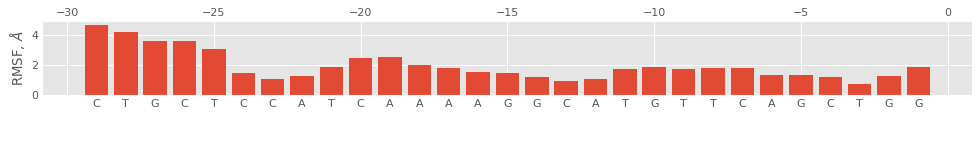

Step    73/73 [100.0%]


## Chain J P RMSF

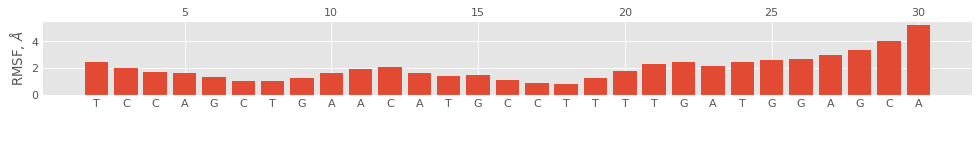

Step    73/73 [100.0%]


SingleLetterAlphabet() alignment with 2 rows and 135 columns
ARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPG...ERA H3
------------------------------------------XG...ERA Query
Type detected= H3


## Chain A CA RMSF

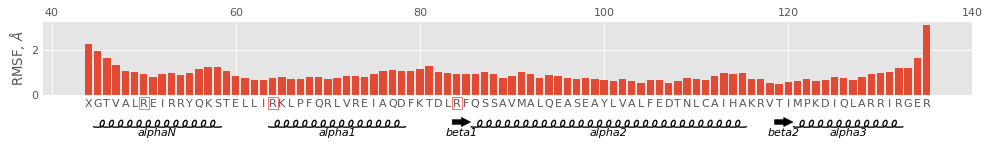

Step    73/73 [100.0%]


SingleLetterAlphabet() alignment with 2 rows and 102 columns
SGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVK...FGG H4
---------------------XRDNIQGITKPAIRRLARRGGVK...FGG Query
Type detected= H4


## Chain B CA RMSF

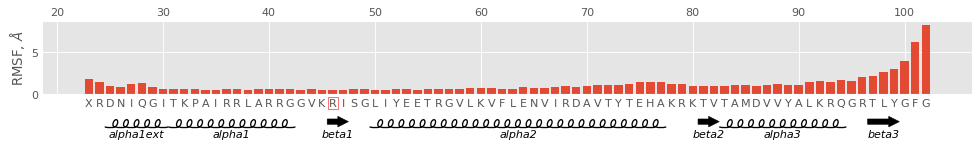

In [18]:
from MDAnalysis.analysis.rms import RMSD
from seq_tools.mpl_shade import plot_on_seq
trj=mda.Universe('GMX_system/sys_ref.pdb', 'big_data/sys_md.xtc')
ref = mda.Universe('GMX_system/sys_ref.pdb')

segIDs=trj.segments.segids
for segID in segIDs:
    calphas = trj.select_atoms("segid %s and name CA P"%segID)
    rmsfer = RMSF(calphas, verbose=True).run()
    resids=trj.select_atoms('segid %s and (protein or nucleic) and  name CA P'%segID).residues.resids
    features={}
    if(len(trj.select_atoms('segid %s and protein'%segID).atoms)>0):
        chain_seq=seq1(''.join(list(trj.select_atoms('segid %s and (protein or nucleic)'%segID).residues.resnames)))
        msa=MultipleSeqAlignment([SeqRecord(Seq(chain_seq),id=segID,name=segID)])
        features=get_hist_ss_in_aln_for_shade(msa,below=True)
        display(Markdown('## Chain %s CA RMSF'%segID))
    if(len(trj.select_atoms('segid %s and nucleic'%segID).atoms)>0):
        chain_seq=''.join(list(trj.select_atoms('segid %s and (protein or nucleic)'%segID).residues.resnames))[1::2]
        display(Markdown('## Chain %s P RMSF'%segID))
    with plt.style.context(('ggplot')):
        plot_on_seq(rmsfer.rmsf,chain_seq,features=features,resids=resids,
                    y_axis_label=r'RMSF, $\AA$',figsize=(15,2),dpi=80)
   
   

## Fluctuation heat plots C$\alpha$
We need to make 2D heatplots showing a) C-alphas position deviation from X-ray, b) side chain RMSD, along the sequence in time.

## Chain I P RMSD

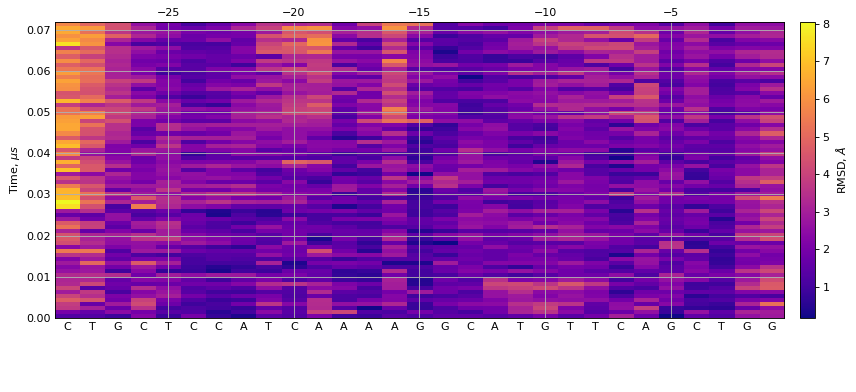

## Chain J P RMSD

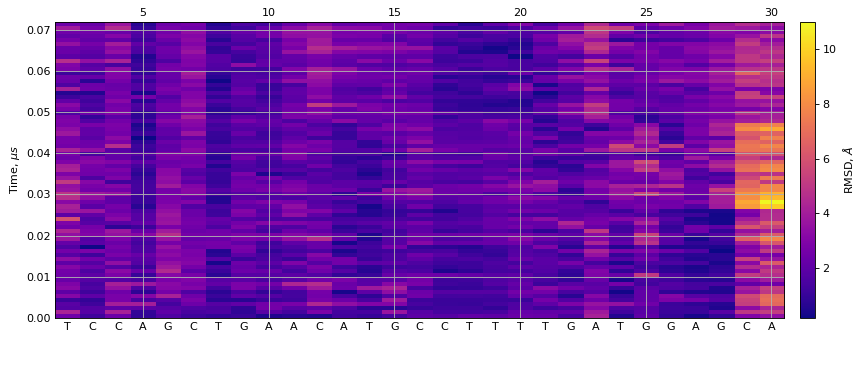

SingleLetterAlphabet() alignment with 2 rows and 135 columns
ARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPG...ERA H3
------------------------------------------XG...ERA Query
Type detected= H3


## Chain A CA RMSD

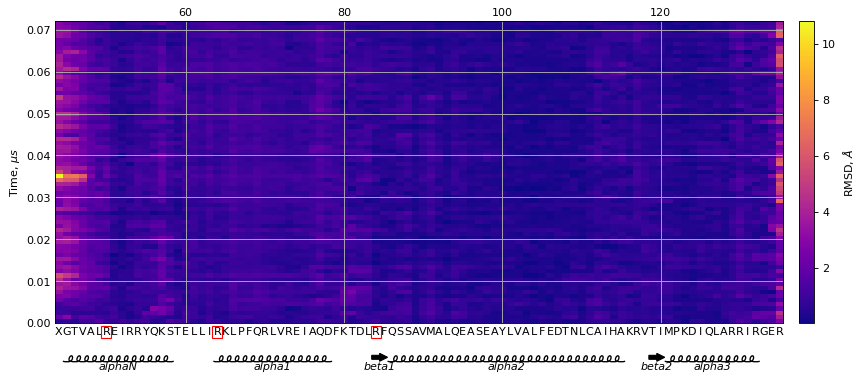

SingleLetterAlphabet() alignment with 2 rows and 102 columns
SGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVK...FGG H4
---------------------XRDNIQGITKPAIRRLARRGGVK...FGG Query
Type detected= H4


## Chain B CA RMSD

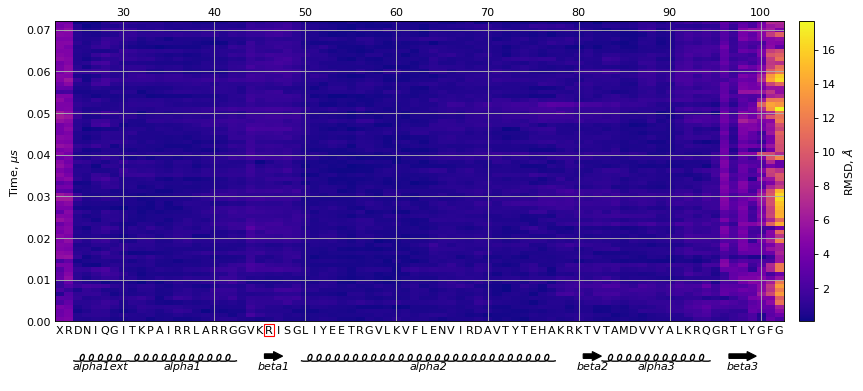

In [20]:
from MDAnalysis.analysis.rms import RMSD
from seq_tools.mpl_shade import heatplot_on_seq
trj=mda.Universe('GMX_system/sys_ref.pdb', 'big_data/sys_md.xtc')
ref = mda.Universe('GMX_system/sys_ref.pdb')

segIDs=trj.segments.segids
for segID in segIDs:
    resids=trj.select_atoms('segid %s and (protein or nucleic) and  name CA P'%segID).residues.resids
    groupselections=["segid %s and (protein or nucleic) and resnum %d  and  name CA P"%(segID,resid) for resid in resids]
    chain_fluc=RMSD(trj, ref,
           select="segid %s and (protein or nucleic) and  name CA P"%segID,             # superimpose on whole backbone of the whole protein
           groupselections=groupselections,                                    # NMP
           filename="big_data/rmsd_all_resids_%s.dat"%segID)
    chain_fluc.run()
    
    
    features={}
    if(len(trj.select_atoms('segid %s and protein'%segID).atoms)>0):
        chain_seq=seq1(''.join(list(trj.select_atoms('segid %s and (protein or nucleic)'%segID).residues.resnames)))
        msa=MultipleSeqAlignment([SeqRecord(Seq(chain_seq),id=segID,name=segID)])
        features=get_hist_ss_in_aln_for_shade(msa,below=True)
        display(Markdown('## Chain %s CA RMSD'%segID))
    if(len(trj.select_atoms('segid %s and nucleic'%segID).atoms)>0):
        chain_seq=''.join(list(trj.select_atoms('segid %s and (protein or nucleic)'%segID).residues.resnames))[1::2]
        display(Markdown('## Chain %s P RMSD'%segID))
    
    
    fig1=heatplot_on_seq(chain_fluc.rmsd[:,3:],chain_seq,filename='big_data/RMSD_vs_T_ch%s.png'%segID,
                      figsize=(10,5),dpi=80,features=features,resids=resids,cmap='plasma',
                      y_axis_values=chain_fluc.rmsd[:,0]/1000, y_axis_label=r"Time, $\mu s$",colorbar_label=r'RMSD, $\AA$')




## Fluctuation heat plots of sidechains or nucleobases
We need to make 2D heatplots showing a) C-alphas position deviation from X-ray, b) side chain RMSD, along the sequence in time.

## Chain I nucleobase RMSF

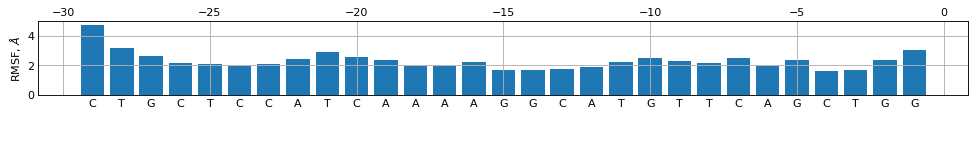

## Chain I nucleobase RMSD

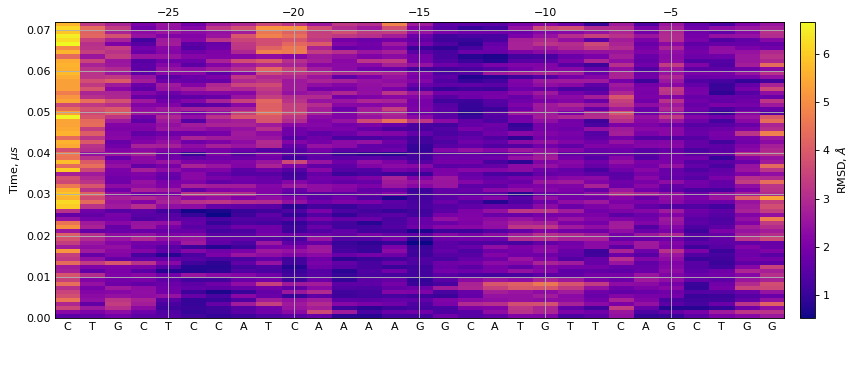

## Chain J nucleobase RMSF

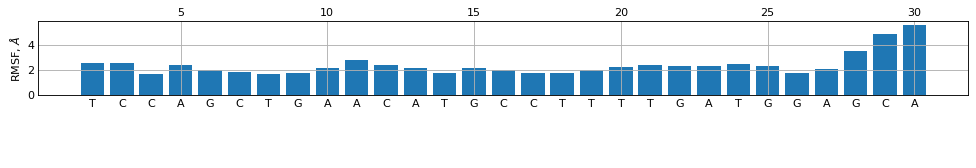

## Chain J nucleobase RMSD

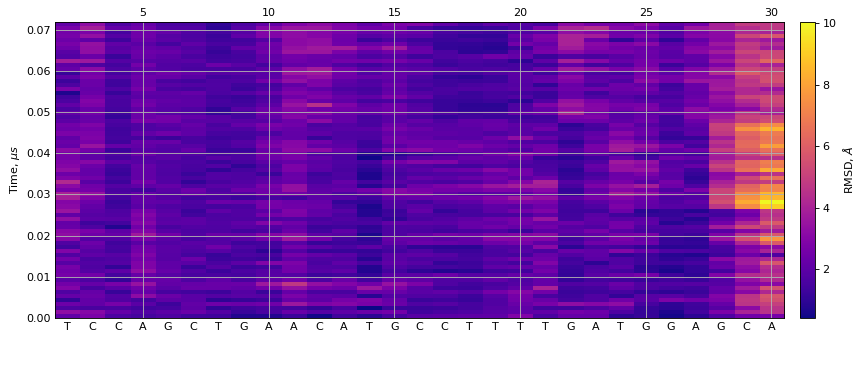

SingleLetterAlphabet() alignment with 2 rows and 135 columns
ARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPG...ERA H3
------------------------------------------XG...ERA Query
Type detected= H3


## Chain A sidechain RMSF

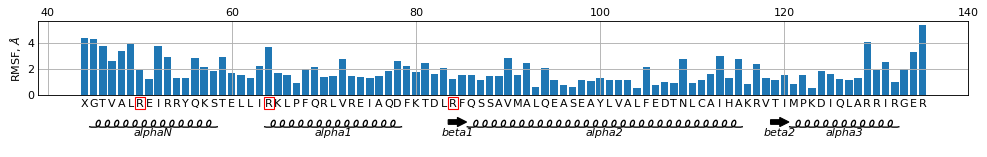

## Chain A sidechain RMSD

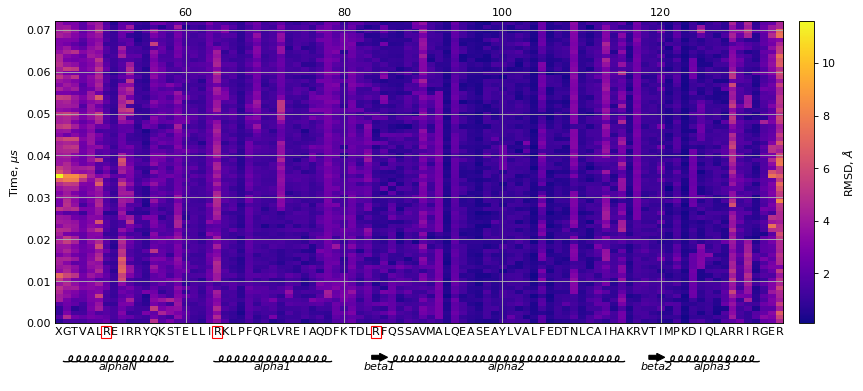

SingleLetterAlphabet() alignment with 2 rows and 102 columns
SGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVK...FGG H4
---------------------XRDNIQGITKPAIRRLARRGGVK...FGG Query
Type detected= H4


## Chain B sidechain RMSF

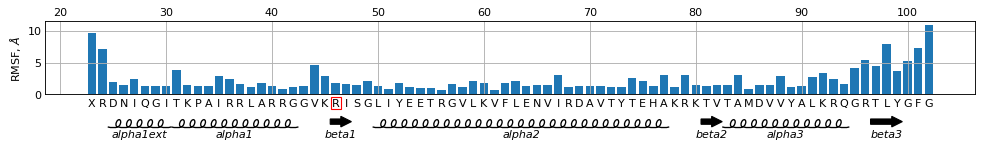

## Chain B sidechain RMSD

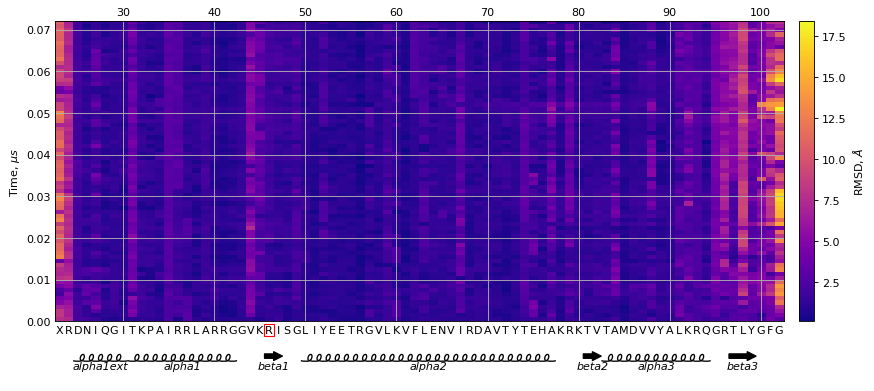

In [21]:
from MDAnalysis.analysis.rms import RMSD
from seq_tools.mpl_shade import heatplot_on_seq
trj=mda.Universe('GMX_system/sys_ref.pdb', 'big_data/sys_md.xtc')
ref = mda.Universe('GMX_system/sys_ref.pdb')

segIDs=trj.segments.segids
for segID in segIDs:
    resids=trj.select_atoms('segid %s and (protein or nucleic) and  name CA P'%segID).residues.resids
    groupselections=["segid %s and (protein or nucleic) and resnum %d  and  ((not backbone) or (name P O1P O2P C1' C2' C3' C4' C5' O3' O4' O5'))"%(segID,resid) for resid in resids]
    chain_fluc=RMSD(trj, ref,
           select="segid %s and (protein or nucleic) and  name CA P"%segID,             # superimpose on whole backbone of the whole protein
           groupselections=groupselections,                                    # NMP
           filename="big_data/rmsd_all_resids_%s.dat"%segID)
    chain_fluc.run()
    
    
    features={}
    if(len(trj.select_atoms('segid %s and protein'%segID).atoms)>0):
        chain_seq=seq1(''.join(list(trj.select_atoms('segid %s and (protein or nucleic)'%segID).residues.resnames)))
        msa=MultipleSeqAlignment([SeqRecord(Seq(chain_seq),id=segID,name=segID)])
        features=get_hist_ss_in_aln_for_shade(msa,below=True)
        display(Markdown('## Chain %s sidechain RMSF'%segID))
        
        rmsf=np.power(np.power(chain_fluc.rmsd.T[3:], 2).mean(1),0.5)
        plot_on_seq(rmsf,chain_seq,features=features,resids=resids,
                y_axis_label=r'RMSF, $\AA$',figsize=(15,2),dpi=80)
    
        display(Markdown('## Chain %s sidechain RMSD'%segID))
        fig1=heatplot_on_seq(chain_fluc.rmsd[:,3:],chain_seq,filename='big_data/RMSD_vs_T_ch%s.png'%segID,
                      figsize=(10,5),dpi=80,features=features,resids=resids,cmap='plasma',
                      y_axis_values=chain_fluc.rmsd[:,0]/1000, y_axis_label=r"Time, $\mu s$",colorbar_label=r'RMSD, $\AA$')



    if(len(trj.select_atoms('segid %s and nucleic'%segID).atoms)>0):
        chain_seq=''.join(list(trj.select_atoms('segid %s and (protein or nucleic)'%segID).residues.resnames))[1::2]
        display(Markdown('## Chain %s nucleobase RMSF'%segID))
        rmsf=np.power(np.power(chain_fluc.rmsd.T[3:], 2).mean(1),0.5)
        plot_on_seq(rmsf,chain_seq,features=features,resids=resids,
                y_axis_label=r'RMSF, $\AA$',figsize=(15,2),dpi=80)
    
        display(Markdown('## Chain %s nucleobase RMSD'%segID))
        fig1=heatplot_on_seq(chain_fluc.rmsd[:,3:],chain_seq,filename='big_data/RMSD_vs_T_ch%s.png'%segID,
                      figsize=(10,5),dpi=80,features=features,resids=resids,cmap='plasma',
                      y_axis_values=chain_fluc.rmsd[:,0]/1000, y_axis_label=r"Time, $\mu s$",colorbar_label=r'RMSD, $\AA$')






## Cluster analysis

Gromacs way

http://manual.gromacs.org/documentation/current/onlinehelp/gmx-rms.html

http://manual.gromacs.org/documentation/current/onlinehelp/gmx-cluster.html

In [22]:
%%bash --out out --err err 
#gromacs implementation 
gmx rms -dt 1 -tu ns -n GMX_system/index.ndx -s GMX_run/7_prod.tpr -f big_data/sys_md.xtc -f2 big_data/sys_md.xtc -m big_data/rmsd-matrix.xpm -o big_data/rmsd.xvg <<!
!Water_and_ions
!Water_and_ions
!

In [23]:
from importlib import reload 
import xpm_plot
reload(xpm_plot)

<module 'xpm_plot' from '/home/_shared/_projects/gmx_template/xpm_plot.py'>

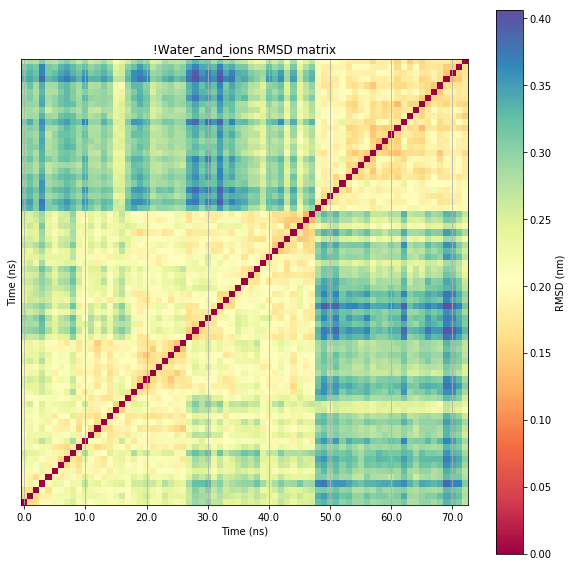

In [24]:
metadata, data = xpm.parse_xpm('big_data/rmsd-matrix.xpm')
xpm.plot_data(data, metadata)


In [25]:
%%bash --out out --err err 
#gromacs implementation 
gmx cluster -n GMX_system/index.ndx -s GMX_run/7_prod.tpr -f big_data/sys_md.xtc -dm big_data/rmsd-matrix.xpm -dt 1000 \
-dist big_data/rms-distribution.xvg -o big_data/clusters.xpm -sz big_data/cluster-sizes.xvg \
-tr big_data/cluster-transitions.xpm -ntr big_data/cluster-transitions.xvg -g big_data/cluster.log \
-clid big_data/cluster-id-over-time.xvg -cl big_data/clusters.pdb -cutoff 0.2 -method gromos <<!
!Water_and_ions
!Water_and_ions
!
#if you get 
#Fatal error:
#hi (0.000000) <= lo (0.000000)
#Likely because cut-off is outside the RMSD range - increase or decrease it!


In [27]:
view_nucl('big_data/clusters.pdb')


NGLWidget(count=7)

### Plot clustering XVG files

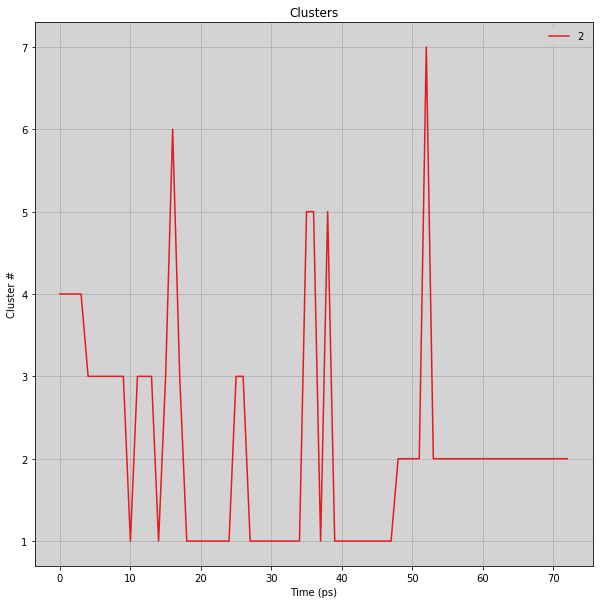

In [28]:
metadata, data = xvg.parse_xvg('big_data/cluster-id-over-time.xvg', 'all')
xvg.plot_data(data, metadata)


## PCA

## PCA analysis

http://manual.gromacs.org/documentation/2018/onlinehelp/gmx-covar.html

In [29]:
%%bash  --out out --err err 
#gromacs implementation
#Choose a group for the least squares fit (choose mainchain+H for protein PCA)
#Choose a group for the covariance analysis (choose mainchain+H for protein PCA)

#gmx covar -s GMX_run/7_prod.tpr -f big_data/h3-h4.xtc -o big_data/eigenval.xvg -v big_data/eigenvect.trr -xpma big_data/covara.xpm <<!
#4
#4
#!
gmx covar -n GMX_system/index.ndx -s GMX_run/7_prod.tpr -f big_data/sys_md.xtc -o big_data/eigenval.xvg -v big_data/eigenvect.trr -xpma big_data/covara.xpm -av big_data/average.pdb -l big_data/covar.log <<!
MainChain+H
MainChain+H
!

In [30]:
#This is now done in step 1_prepare
#%%bash --out out --err err
## Let's make backbone file
#gmx trjconv -f GMX_system/init_solv_ions.pdb -s GMX_run/7_prod.tpr -o big_data/bb_xray.pdb << !
#4
#!
#gmx trjconv -f GMX_system/init_solv_ions.pdb -s GMX_run/7_prod.tpr -o big_data/bb-h_xray.pdb << !
#7
#!

In [49]:
from importlib import reload 
import MDAnalysis as mda
import xpm_plot
import xvg_plot


reload(xvg_plot)
reload(xpm_plot)

<module 'xpm_plot' from '/home/_shared/_projects/gmx_template/xpm_plot.py'>

No handles with labels found to put in legend.


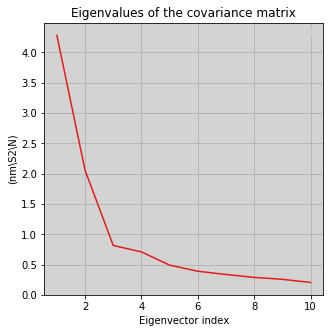

In [32]:
metadata, data = xvg.parse_xvg('big_data/eigenval.xvg', 'all')
data=np.array(data)
data=data[:,0:10]
xvg.plot_data(data, metadata,figsize=(5,5))


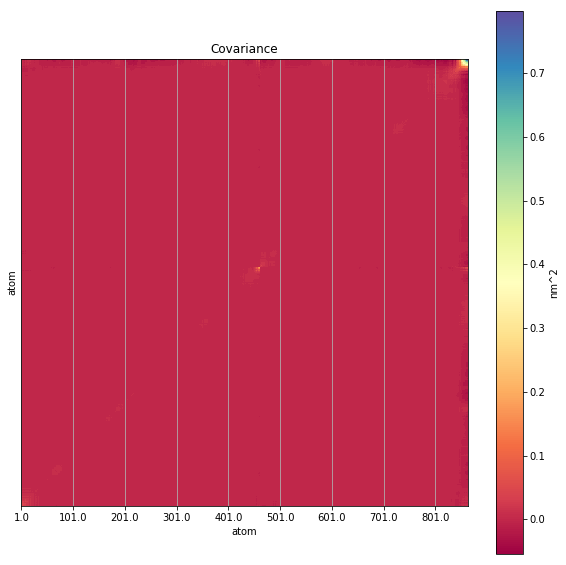

In [33]:
metadata, data = xpm.parse_xpm('big_data/covara.xpm')
xpm.plot_data(data, metadata)


### Let's filter our trajectory along one or several eigenvectors
http://manual.gromacs.org/documentation/2018/onlinehelp/gmx-anaeig.html

In [34]:
%%bash --out out --err err 
gmx anaeig -v big_data/eigenvect.trr -dt 10000 -s GMX_run/7_prod.tpr -n GMX_system/index.ndx -f big_data/sys_md.xtc -first 1 -last 1 -filt big_data/filtered.xtc <<!
MainChain+H
MainChain+H
!
# We need to center it
gmx trjconv -f big_data/filtered.xtc -s GMX_system/prot_bb-h_ref.pdb -o big_data/filtered.xtc -fit rot+trans << !
System
System
!

In [37]:
view_nucl('GMX_system/prot_bb-h_ref.pdb','big_data/filtered.xtc')

NGLWidget(count=8)

#### Let's make movie

In [38]:
!rm tmp/dat/*
!vmd -dispdev none -e VMD_scripts/view_nucl.tcl -args GMX_system/prot_bb-h_ref.pdb big_data/filtered.xtc "$movtitle, filtered 1 eigenvector" 0 1 1 1 > /dev/null
!rm big_data/movie_pca_filt.*
!ffmpeg -i tmp/dat/%d.dat.tga -s 1000x750 -q:v 0 -pix_fmt yuv420p  big_data/movie_pca_filt.mp4 > /dev/null 2>&1
#!ffmpeg -i tmp/dat/%d.dat.tga -s 1000x750 -q:v 0 -pix_fmt yuv420p  big_data/movie_pca_filt.wmv

/opt/miniconda3/envs/moldyn/vmd/vmd_LINUXAMD64: /usr/lib/x86_64-linux-gnu/libGL.so.1: no version information available (required by /opt/miniconda3/envs/moldyn/vmd/vmd_LINUXAMD64)


In [39]:
%%HTML
<video width="320" height="240" controls>
  <source src="big_data/movie_pca_filt.mp4" type="video/mp4">
</video>

### Let's make interpolations for 6 PCA vectors
http://manual.gromacs.org/documentation/2018/onlinehelp/gmx-anaeig.html

In [40]:
%%bash --out out --err err
gmx anaeig -v big_data/eigenvect.trr -s GMX_run/7_prod.tpr -n GMX_system/index.ndx -f big_data/sys_md.xtc -first 1 -last 6 -nframes 50  -extr big_data/interp.xtc<<!
MainChain+H
MainChain+H
!

for i in `seq 1 6`; do
echo $i
gmx trjconv -f big_data/interp$i.xtc -s GMX_system/prot_bb-h_ref.pdb -o big_data/interp$i.xtc -fit rot+trans << !
System
System
!
done

In [41]:
view_nucl('GMX_system/prot_bb-h_ref.pdb','big_data/interp1.xtc',gui=True)

/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/MDAnalysis/coordinates/XDR.py:195: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


NGLWidget(count=50)

In [42]:
#!vmd -e VMD_scripts/view_nucl.tcl -args GMX_system/prot_bb-h_ref.pdb big_data/interp1.xtc "MD, PCA eigenv. 1 interp" 0 0 0 0


In [43]:
%%writefile tmp/render.sh
#!/bin/bash
for p in `seq 1 6`; do 
rm tmp/dat/* ;
vmd -dispdev none -e VMD_scripts/view_nucl.tcl -args GMX_system/prot_bb-h_ref.pdb big_data/interp$p.xtc "$1, PCA eigenv. $p interp." 0 1 1 0 > /dev/null

echo "Let's add back frames" 
for i in `seq 2 49`; do
f=`expr 100 - $i`
echo $f
cp tmp/dat/$i.dat.tga tmp/dat/$f.dat.tga
done 

# Let's generate videos
rm big_data/movie_pca$p.* ;
ffmpeg -i tmp/dat/%d.dat.tga -s 1000x750 -q:v 0 -pix_fmt yuv420p  big_data/movie_pca$p.mp4 > /dev/null 2>&1
done 

#This concats a movie with its reverse
#ffmpeg -i tmp/dat/%d.dat.tga -s 1000x750 -q:v 0 -pix_fmt yuv420p  -filter_complex "[0:v]reverse,fifo[r];[0:v][r] concat=n=2:v=1 [v]" -map "[v]" big_data/movie_pca1.mov



Overwriting tmp/render.sh


In [44]:
!chmod u+x tmp/render.sh
!tmp/render.sh "$movtitle" > /dev/null 2>&1

In [45]:
%%HTML
<video width="320" height="240" controls loop>
  <source src="big_data/movie_pca1.mp4" type="video/mp4">
</video>
<video width="320" height="240" controls loop>
  <source src="big_data/movie_pca2.mp4" type="video/mp4">
</video>
<video width="320" height="240" controls loop>
  <source src="big_data/movie_pca3.mp4" type="video/mp4">
</video>
<video width="320" height="240" controls loop>
  <source src="big_data/movie_pca4.mp4" type="video/mp4">
</video>
<video width="320" height="240" controls loop>
  <source src="big_data/movie_pca5.mp4" type="video/mp4">
</video>
<video width="320" height="240" controls loop>
  <source src="big_data/movie_pca6.mp4" type="video/mp4">
</video>

## Let's plot projections

In [46]:
%%bash --out out --err err
gmx anaeig -v big_data/eigenvect.trr -s GMX_run/7_prod.tpr -n GMX_system/index.ndx -f big_data/sys_md.xtc -first 1 -last 2 -2d big_data/2d_pca12.xvg<<!
MainChain+H
MainChain+H
!

No handles with labels found to put in legend.


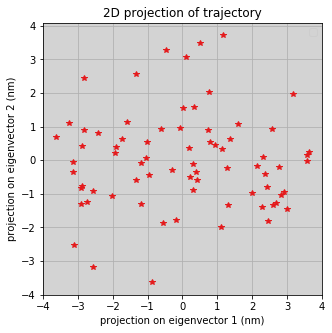

In [51]:
metadata, data = xvg.parse_xvg('big_data/2d_pca12.xvg', 'all')
xvg.plot_data(data, metadata,figsize=(5,5),type='b*')

In [52]:
%%bash --out out --err err
gmx anaeig -v big_data/eigenvect.trr -s GMX_run/7_prod.tpr -n GMX_system/index.ndx -f big_data/sys_md.xtc -first 2 -last 3 -2d big_data/2d_pca23.xvg<<!
MainChain+H
MainChain+H
!

No handles with labels found to put in legend.


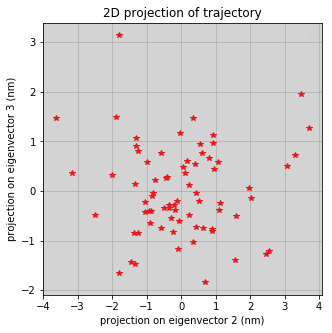

In [53]:
metadata, data = xvg.parse_xvg('big_data/2d_pca23.xvg', 'all')
xvg.plot_data(data, metadata,figsize=(5,5),type='b*')

In [54]:
%%bash --out out --err err
gmx anaeig -v big_data/eigenvect.trr -s GMX_run/7_prod.tpr -n GMX_system/index.ndx -f big_data/sys_md.xtc -first 3 -last 4 -2d big_data/2d_pca34.xvg<<!
MainChain+H
MainChain+H
!

No handles with labels found to put in legend.


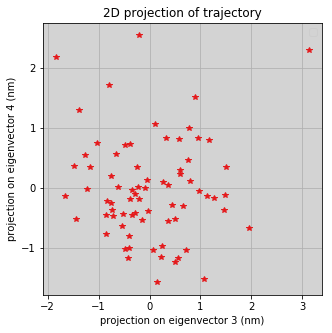

In [55]:
metadata, data = xvg.parse_xvg('big_data/2d_pca34.xvg', 'all')
xvg.plot_data(data, metadata,figsize=(5,5),type='b*')

In [56]:
%%bash --out out --err err
gmx anaeig -v big_data/eigenvect.trr -s GMX_run/7_prod.tpr -n GMX_system/index.ndx -f big_data/sys_md.xtc -first 4 -last 5 -2d big_data/2d_pca45.xvg<<!
MainChain+H
MainChain+H
!

No handles with labels found to put in legend.


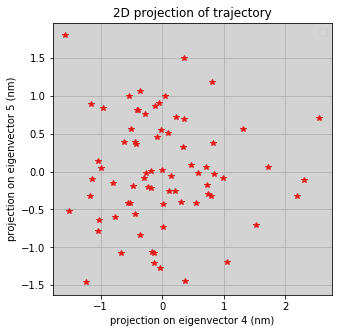

In [57]:
metadata, data = xvg.parse_xvg('big_data/2d_pca45.xvg', 'all')
xvg.plot_data(data, metadata,figsize=(5,5),type='b*')